<a href="https://colab.research.google.com/github/saimathura/deeplearning-MDSC302/blob/main/22233_Assignment_transferLearning_Hymenoptera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saimathurakrishnan","key":"93f1782054d1d824aebb7eace9b87a9b"}'}

In [4]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download thedatasith/hymenoptera

 99% 45.0M/45.6M [00:00<00:00, 167MB/s]
100% 45.6M/45.6M [00:00<00:00, 150MB/s]


In [7]:
!unzip hymenoptera.zip

Archive:  hymenoptera.zip
  inflating: README.md               
  inflating: cover.jpg               
  inflating: hymenoptera/train/ants/0013035.jpg  
  inflating: hymenoptera/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera/train/ants/1473187633_63ccaacea6.jpg  
  inflating: hymenoptera/train/ants/148715752_302c84f5a4.jpg  
  inflating: hymeno

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


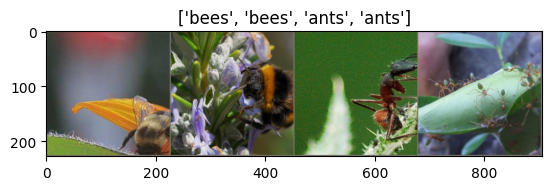

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
import os
import time
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Store loss and accuracy history
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                    train_acc_history.append(epoch_acc)
                else:
                    val_loss_history.append(epoch_loss)
                    val_acc_history.append(epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Example usage:
# model, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(model, criterion, optimizer, scheduler, num_epochs=25)


In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


In [14]:
model_ft , train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5943 Acc: 0.6680
val Loss: 0.2104 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5578 Acc: 0.7500
val Loss: 0.3502 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4987 Acc: 0.8115
val Loss: 0.5710 Acc: 0.8235

Epoch 3/24
----------
train Loss: 0.5711 Acc: 0.8115
val Loss: 0.2623 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.5976 Acc: 0.7582
val Loss: 0.3059 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.4263 Acc: 0.8443
val Loss: 0.3293 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.3993 Acc: 0.8402
val Loss: 0.2293 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3543 Acc: 0.8648
val Loss: 0.2155 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3476 Acc: 0.8279
val Loss: 0.2088 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2552 Acc: 0.9098
val Loss: 0.2133 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2564 Acc: 0.9098
val Loss: 0.2231 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3586 Acc: 0.8484
val Loss: 0.1933 Acc: 0.9346

Ep

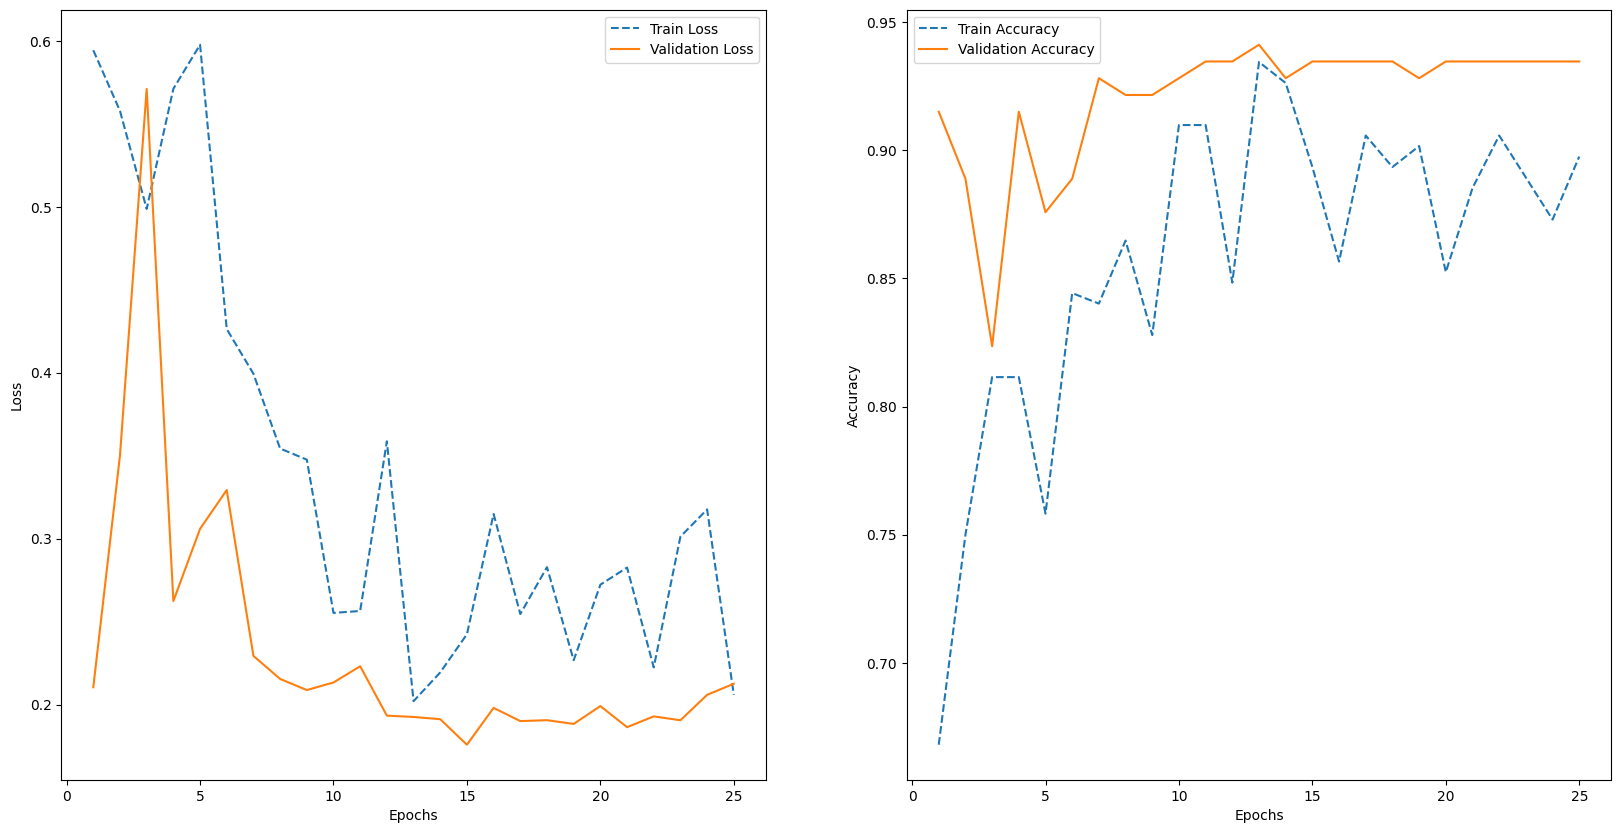

In [43]:
 # Plot training and validation loss curves
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_hist) + 1), train_loss_hist, label='Train Loss',linestyle = "dashed")
plt.plot(range(1, len(val_loss_hist) + 1), val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Plot training and validation accuracy curves
plt.subplot(1, 2, 2)
import numpy as np
train_acc = [x.item() for x in train_acc_hist]
val_acc = [x.item() for x in val_acc_hist]
plt.plot(range(1, len(train_acc_hist) + 1), train_acc, label='Train Accuracy',linestyle = "dashed")
plt.plot(range(1, len(val_acc_hist) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


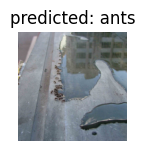

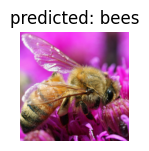

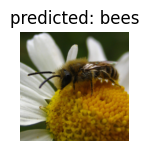

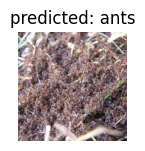

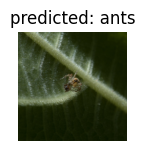

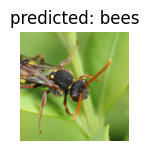

In [44]:
visualize_model(model_ft)

In [45]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [46]:
model_conv , train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6644 Acc: 0.6393
val Loss: 0.2257 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5292 Acc: 0.7623
val Loss: 0.3904 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.7307 Acc: 0.7295
val Loss: 0.2844 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.5087 Acc: 0.7910
val Loss: 0.2017 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4819 Acc: 0.7910
val Loss: 0.3153 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.5116 Acc: 0.7787
val Loss: 0.2906 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.4895 Acc: 0.8115
val Loss: 0.2070 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3566 Acc: 0.8525
val Loss: 0.1937 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3667 Acc: 0.8525
val Loss: 0.2063 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.4106 Acc: 0.8238
val Loss: 0.1991 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.4369 Acc: 0.8402
val Loss: 0.2378 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3210 Acc: 0.8607
val Loss: 0.1860 Acc: 0.9477

Ep

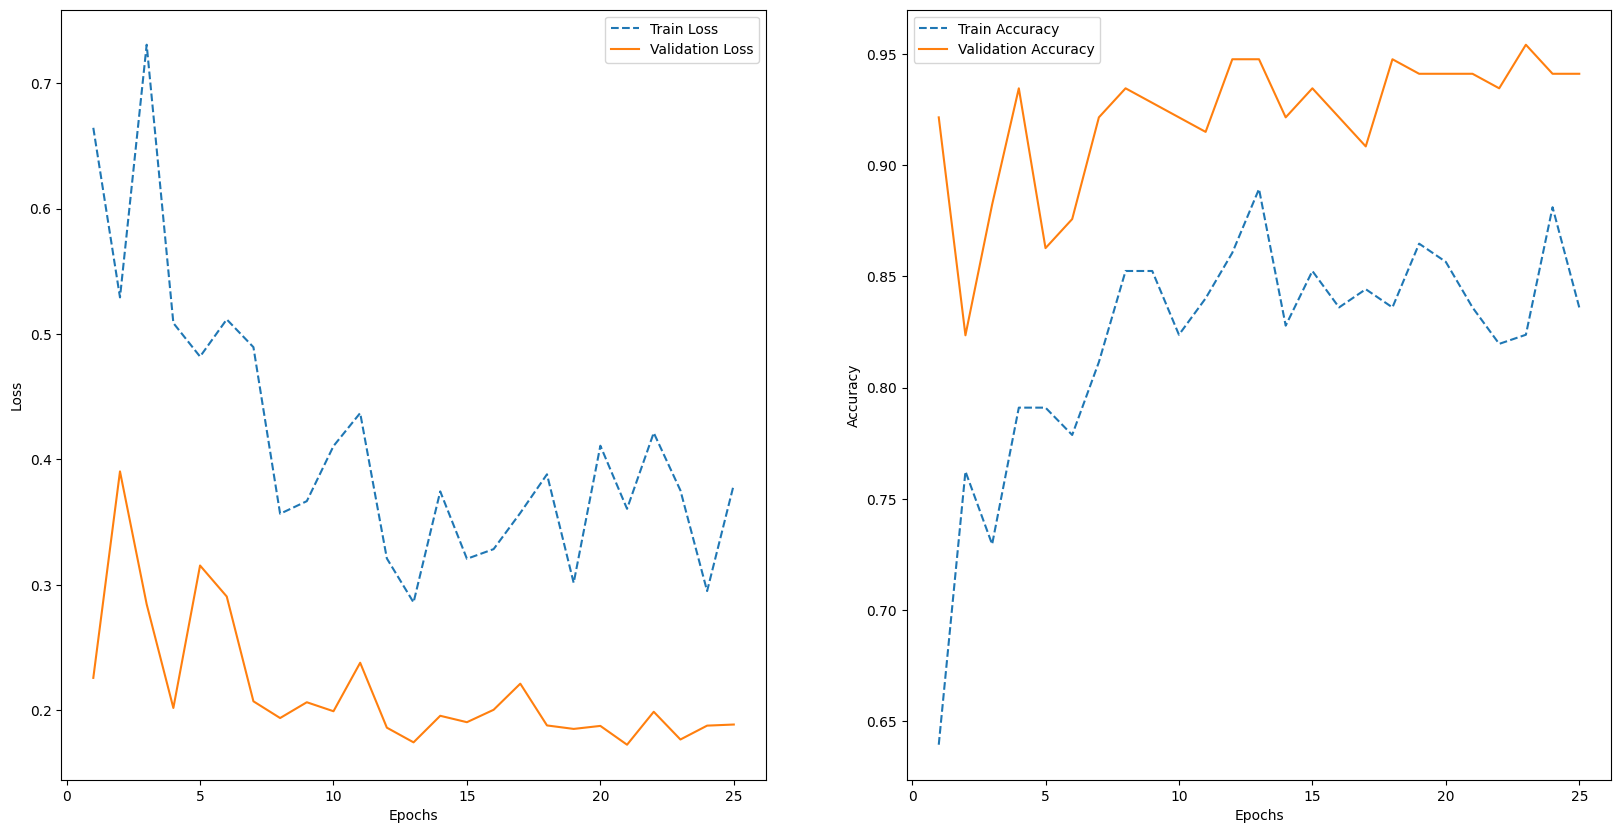

In [47]:
 # Plot training and validation loss curves
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_hist) + 1), train_loss_hist, label='Train Loss',linestyle = "dashed")
plt.plot(range(1, len(val_loss_hist) + 1), val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Plot training and validation accuracy curves
plt.subplot(1, 2, 2)
import numpy as np
train_acc = [x.item() for x in train_acc_hist]
val_acc = [x.item() for x in val_acc_hist]
plt.plot(range(1, len(train_acc_hist) + 1), train_acc, label='Train Accuracy',linestyle = "dashed")
plt.plot(range(1, len(val_acc_hist) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


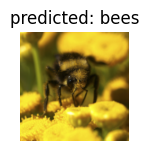

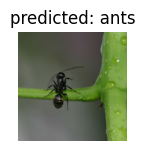

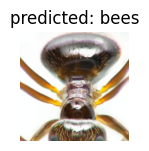

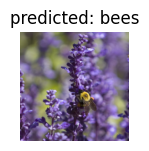

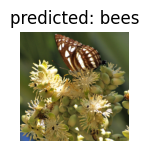

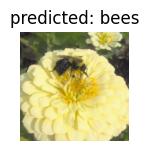

In [48]:
visualize_model(model_conv)

plt.ioff()
plt.show()